In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [5]:
station = pd.read_sql("SELECT * FROM station", conn)
station

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [6]:
measurement = pd.read_sql("SELECT * FROM measurement", conn)
measurement.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect = True)
# reflect the tables

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date_list = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = dt.datetime.strptime(most_recent_date_list[0], '%Y-%m-%d')
print(most_recent_date)

2017-08-23 00:00:00


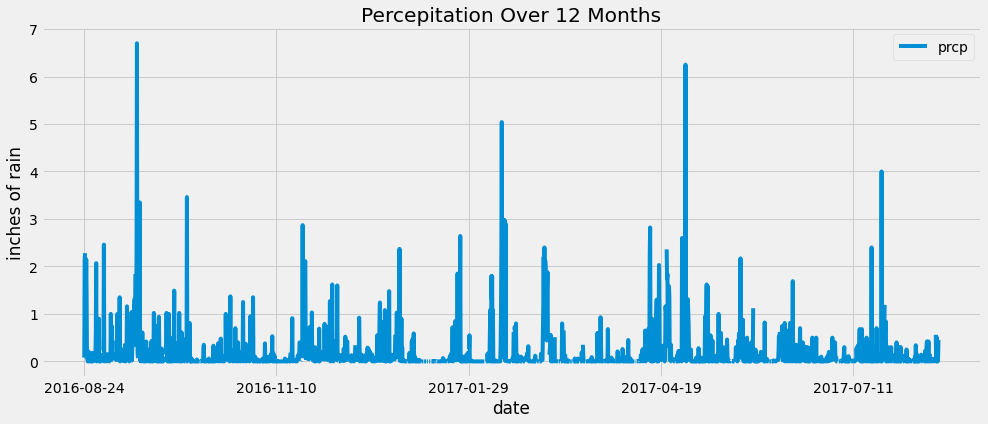

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
oldest_date = str(most_recent_date - dt.timedelta(days=365))

# Perform a query to retrieve the data and precipitation scores
data_twelve = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > oldest_date).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df_twelve = pd.DataFrame(data_twelve, columns=['date', 'prcp'])
df_twelve.head()
df_twelve.set_index('date', inplace=True)
df_twelve.plot(figsize=(15, 6))
plt.xlabel("date")
plt.ylabel("inches of rain")
plt.title("Percepitation Over 12 Months")
plt.show()
# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data




In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = df_twelve.agg({'prcp': ['count','mean', 'median','var', 'std', 'sem']})
print(summary_stats)

               prcp
count   2015.000000
mean       0.176462
median     0.020000
var        0.211865
std        0.460288
sem        0.010254


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(Station).count()
print(f"There are {number_stations} stations in the dataset.")


There are 9 stations in the dataset.


In [24]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_que = session.query(Station)
measure_que = session.query(Measurement)
station_list = []
counts_station = []
for stat in station_que:
    station_list.append(stat.station)
for station in station_list:
    counter = 0
    for me in measure_que:
        if (me.station == station):
            counter = counter + 1
    counts_station.append(counter)
count_dict = {'Station': station_list, 'Count': counts_station}
count_df = pd.DataFrame(count_dict)
count_df = count_df.sort_values(by=['Count'], ascending=False)
count_df.head()

,Station,Count
6,USC00519281,2772
0,USC00519397,2724
1,USC00513117,2709
5,USC00519523,2669
8,USC00516128,2612


In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_station_id = count_df["Station"][6]
print(max_station_id)
max_station_que = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == max_station_id).\
    order_by(Measurement.date).all()
df_max = pd.DataFrame(max_station_que, columns=['date', 'tobs'])
summary_stats_two = df_max.agg({'tobs': ['min','max', 'mean']})
print(f'The id of the most active station is {max_station_id}')
print(summary_stats_two)

USC00519281
The id of the most active station is USC00519281
           tobs
min   54.000000
max   85.000000
mean  71.663781


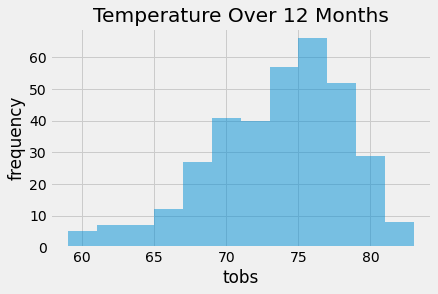

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_station_que_laster = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == max_station_id).\
    filter(Measurement.date > oldest_date).\
    order_by(Measurement.date).all()
df_laster = pd.DataFrame(max_station_que_laster, columns=['date', 'tobs'])
df_laster.hist(bins=12, alpha=0.5)
plt.tight_layout()
plt.xlabel("tobs")
plt.ylabel("frequency")
plt.title("Temperature Over 12 Months")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()